<a href="https://colab.research.google.com/github/2alstj/2alstj.github.io/blob/main/Softmax_Regressin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리 선언

In [ ]:
import torch                                  #Pytorch main module
import torchvision.datasets as dsets          #Open dataset loading
import torchvision.transforms as transforms   #Transform Image to Tensor
from torch.utils.data import DataLoader       #Loading Dataset by minibatch
import torch.nn as nn                         #Linear layer
import matplotlib.pyplot as plt               #python plot library
import random


# 2. CUDA 설정
##CUDA란?
- nvidia에서 만든 gpu를 위한 병렬 연산 플렛폼이자 프로그래밍 도구이다.
- `torch.cuda.is_available()`은 GPU사용 가능 여부를 반환
- `torch.device()`는 텐서/모델이 올라갈 장치를 결정(cpu or gpu)

딥러닝에서는 GPU를 사용하는 것이 속도면에서 매우 유리하며, PyTorch는 `.to("cuda")` 또는 `.to("cpu")`로 쉽게 전환이 가능하다.

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("device : ", device)

device :  cuda


# 3. 재현성(시드 고정)
- 실험 결과가 매번 달라지지 않게 하기 위한 시드 고정 코드

In [ ]:
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed(777)

# 4. 하이퍼파라미터 정의
- `epochs` : 전체 데이터셋 반복 학습 횟수
- `batch_size` : 한번에 학습할 데이터 수

In [ ]:
training_epochs = 15
batch_size = 100

# 5. MNIST 데이터 셋 로딩
- MNIST 데이터 셋 다운로드

In [ ]:
mnist_train = dsets.MNIST(root = 'MNIST_data',
                          train = True,
                          transform = transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root = 'MNIST_data',
                         train = False,
                         transform = transforms.ToTensor(),
                         download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 491kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.06MB/s]


# 6. DataLoader 생성
- 배치 단위로 데이터를 불러옴,
- `drop_last=True` : 남는 샘플을 버려서 배치들의 크기를 일정하게 유지

In [ ]:
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# 7. 모델 정의
- 입력 : 28 * 28 = 784
- 출력 : 0 ~ 9 -> 10

In [ ]:
linear = nn.Linear(784, 10, bias=True).to('cuda')

# 8. 손실 함수, 옵티마이저
- `CrossEntropyLoss()` : softmax + negative log likelihood를 내부적으로 처리
- `SGD` : 확률적 경사하강법(learning rate = 0.1)

In [ ]:
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = torch.optim.SGD(linear.parameters(),lr=0.1)

# 9. 학습 루프
- `view(-1,784)` : Linear모델에서 입력이 (28 * 28)이어야 함. X.shape = [100, 1, 28, 28]을 flatten 필요


In [ ]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for X, Y in data_loader:
    X = X.view(-1, 28 * 28).to('cuda')
    Y = Y.to('cuda')

    hypothesis = linear(X)
    cost = criterion(hypothesis, Y)

    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  print('Epoch : ','%04d' % (epoch + 1), 'Cost = {:.9f}'.format(avg_cost))

Epoch :  0001 Cost = 0.535150588
Epoch :  0002 Cost = 0.359577715
Epoch :  0003 Cost = 0.331264287
Epoch :  0004 Cost = 0.316404670
Epoch :  0005 Cost = 0.307106972
Epoch :  0006 Cost = 0.300456554
Epoch :  0007 Cost = 0.294933438
Epoch :  0008 Cost = 0.290956199
Epoch :  0009 Cost = 0.287074119
Epoch :  0010 Cost = 0.284515619
Epoch :  0011 Cost = 0.281914055
Epoch :  0012 Cost = 0.279526889
Epoch :  0013 Cost = 0.277636588
Epoch :  0014 Cost = 0.275874794
Epoch :  0015 Cost = 0.274422765


# 10. 정확도 테스트
- `argmax` :

In [ ]:
with torch.no_grad():
  X_test = mnist_test.test_data.view(-1, 28 * 28).float().to('cuda')
  Y_test = mnist_test.test_labels.to('cuda')

  prediction = linear(X_test)
  correct_prediction = torch.argmax(prediction, 1) == Y_test
  accuracy = correct_prediction.float().mean()
  print("Accuarcy : " , accuracy.item())

Accuarcy :  0.8883000016212463


# 11. 단일 샘플 예측 확인

Label :  8
Prediction :  8


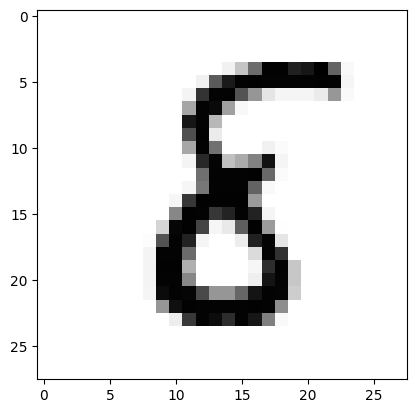

In [ ]:


r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r+1].view(-1, 28 * 28).float().to('cuda')
Y_single_data = mnist_test.test_labels[r:r+1].to('cuda')

print("Label : ", Y_single_data.item())

single_prediction = linear(X_single_data)
print("Prediction : ", torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()